# This notebook will provide a model able to predict bounding box in order to fed a CNN classification model then. The dataset used to do that can be found in Kaggle : https://www.kaggle.com/datasets/tannergi/chess-piece-detection

In [1]:
import os
import numpy as np
import PIL
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import struct
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import models
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, UpSampling2D, add, concatenate, Conv2D, Lambda, BatchNormalization, LeakyReLU, ZeroPadding2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

In [3]:
def get_dataset_dicts(annotation_path, image_path, classes):
    dataset_dicts = []
    for filename in os.listdir(annotation_path):
        if filename != '.ipynb_checkpoints':
            record = {}
            root = ET.parse(os.path.join(annotation_path, filename)).getroot()
            record["file_name"] = os.path.join(image_path, root.find('filename').text)
            record["height"] = 2248
            record["width"] = 4000

            objs = []
            for member in root.findall('object'):
                obj = {
                  'bbox': [int(member[4][0].text), int(member[4][1].text), int(member[4][2].text), int(member[4][3].text)],
                  'category_id': classes.index(member[0].text),
                  "iscrowd": 0}
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts

In [4]:
dataset = get_dataset_dicts('Dataset\\detection\\annotations', 'Dataset\\detection\\images', classes)

In [ ]:
import os
import argparse
import json
import xml.etree.ElementTree as ET
from typing import Dict, List
from tqdm import tqdm
import re


def get_label2id(labels_path: str) -> Dict[str, int]:
    """id is 1 start"""
    with open(labels_path, 'r') as f:
        labels_str = f.read().split()
    labels_ids = list(range(1, len(labels_str)+1))
    return dict(zip(labels_str, labels_ids))


def get_annpaths(ann_dir_path: str = None,
                 ann_ids_path: str = None,
                 ext: str = '',
                 annpaths_list_path: str = None) -> List[str]:
    # If use annotation paths list
    if annpaths_list_path is not None:
        with open(annpaths_list_path, 'r') as f:
            ann_paths = f.read().split()
        return ann_paths

    # If use annotaion ids list
    ext_with_dot = '.' + ext if ext != '' else ''
    with open(ann_ids_path, 'r') as f:
        ann_ids = f.read().split()
    ann_paths = [os.path.join(ann_dir_path, aid+ext_with_dot) for aid in ann_ids]
    return ann_paths


def get_image_info(annotation_root, extract_num_from_imgid=True):
    path = annotation_root.findtext('path')
    if path is None:
        filename = annotation_root.findtext('filename')
    else:
        filename = os.path.basename(path)
    img_name = os.path.basename(filename)
    img_id = os.path.splitext(img_name)[0]
    if extract_num_from_imgid and isinstance(img_id, str):
        img_id = int(re.findall(r'\d+', img_id)[0])

    size = annotation_root.find('size')
    width = int(size.findtext('width'))
    height = int(size.findtext('height'))

    image_info = {
        'file_name': filename,
        'height': height,
        'width': width,
        'id': img_id
    }
    return image_info


def get_coco_annotation_from_obj(obj, label2id):
    label = obj.findtext('name')
    assert label in label2id, f"Error: {label} is not in label2id !"
    category_id = label2id[label]
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.findtext('xmin')) - 1
    ymin = int(bndbox.findtext('ymin')) - 1
    xmax = int(bndbox.findtext('xmax'))
    ymax = int(bndbox.findtext('ymax'))
    assert xmax > xmin and ymax > ymin, f"Box size error !: (xmin, ymin, xmax, ymax): {xmin, ymin, xmax, ymax}"
    o_width = xmax - xmin
    o_height = ymax - ymin
    ann = {
        'area': o_width * o_height,
        'iscrowd': 0,
        'bbox': [xmin, ymin, o_width, o_height],
        'category_id': category_id,
        'ignore': 0,
        'segmentation': []  # This script is not for segmentation
    }
    return ann


def convert_xmls_to_cocojson(annotation_paths: List[str],
                             label2id: Dict[str, int],
                             output_jsonpath: str,
                             extract_num_from_imgid: bool = True):
    output_json_dict = {
        "images": [],
        "type": "instances",
        "annotations": [],
        "categories": []
    }
    bnd_id = 1  # START_BOUNDING_BOX_ID, TODO input as args ?
    print('Start converting !')
    for a_path in tqdm(annotation_paths):
        # Read annotation xml
        ann_tree = ET.parse(a_path)
        ann_root = ann_tree.getroot()

        img_info = get_image_info(annotation_root=ann_root,
                                  extract_num_from_imgid=extract_num_from_imgid)
        img_id = img_info['id']
        output_json_dict['images'].append(img_info)

        for obj in ann_root.findall('object'):
            ann = get_coco_annotation_from_obj(obj=obj, label2id=label2id)
            ann.update({'image_id': img_id, 'id': bnd_id})
            output_json_dict['annotations'].append(ann)
            bnd_id = bnd_id + 1

    for label, label_id in label2id.items():
        category_info = {'supercategory': 'none', 'id': label_id, 'name': label}
        output_json_dict['categories'].append(category_info)

    with open(output_jsonpath, 'w') as f:
        output_json = json.dumps(output_json_dict)
        f.write(output_json)

In [345]:
dataset[:5]

[{'file_name': 'Dataset\\detection\\images\\IMG_1989.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1780, 573, 2319, 1442],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1990.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1880, 1052, 2383, 1532],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1991.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1325, 1112, 1564, 1378],
    'category_id': 0,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1992.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1613, 342, 2001, 1098],
    'category_id': 1,
    'iscrowd': 0}]},
 {'file_name': 'Dataset\\detection\\images\\IMG_1993.JPG',
  'height': 2248,
  'width': 4000,
  'annotations': [{'bbox': [1795, 880, 2165, 1280],
    'category_id': 1,
    'iscrowd': 0}]}]

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


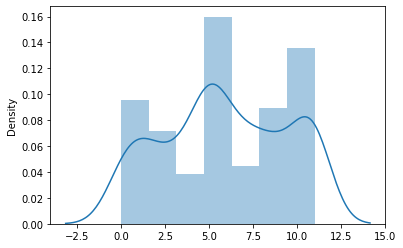

In [281]:
classification_ = np.array([piece['category_id'] for count in range(len(dataset)) for piece in dataset[count]['annotations']])
sns.distplot(classification_)
plt.show()

The dataset is relatively unbalanced

In [87]:
height = np.mean(np.array([dataset[count]['height'] for count in range(len(dataset))]))
width = np.mean(np.array([dataset[count]['width'] for count in range(len(dataset))]))

print(height, width)

2248.0 4000.0


All images have the same dimension. So we will scale dimension of bounding box to be between [0,1]

In [346]:
bounding_box=  np.array([piece['bbox'] for count in range(len(dataset)) for piece in dataset[count]['annotations']])

In [347]:
bounding_box_scaled = bounding_box /np.array([width, height ,width, height])

In [348]:
bounding_box_scaled[:5]

array([[0.445     , 0.25489324, 0.57975   , 0.64145907],
       [0.47      , 0.46797153, 0.59575   , 0.68149466],
       [0.33125   , 0.49466192, 0.391     , 0.61298932],
       [0.40325   , 0.15213523, 0.50025   , 0.48843416],
       [0.44875   , 0.39145907, 0.54125   , 0.56939502]])

In [349]:
bounding_box_scaled.shape

(398, 4)

In [119]:
print(np.min(bounding_box_scaled), np.max(bounding_box_scaled))

0.00044483985765124553 1.0


## Loading images

In [146]:
img = []
for file in dataset:
    temp_img = PIL.Image.open(file['file_name'])
    temp_img = temp_img.resize((224,224),PIL.Image.ANTIALIAS)
    img.append(np.array(temp_img))
img = np.array(img)

C:\Users\thoma\AppData\Local\Temp\ipykernel_2920\1486849621.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  temp_img = temp_img.resize((224,224),PIL.Image.ANTIALIAS)


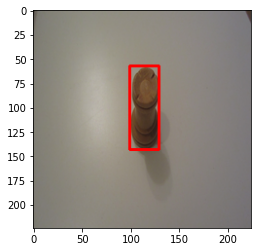

In [168]:
xmin,ymin,xmax,ymax = (bounding_box_scaled[0] * 224).astype(int)
plt.imshow(cv2.rectangle(img[0], (xmin,ymin), (xmax,ymax), (255,0,0), 2))

In [229]:
one_hot = OneHotEncoder(handle_unknown='ignore')
labels = np.array(classification_).reshape(-1,1)
one_hot.fit(labels)
one_hot_classification = one_hot.transform(labels).toarray()

In [231]:
X_train, X_test, bbs_train, bbs_test = train_test_split(img, bounding_box_scaled, test_size=0.2, random_state=0)
classif_train, classif_test, _, _ = train_test_split(one_hot_classification, one_hot_classification, test_size=0.2, random_state=0)

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

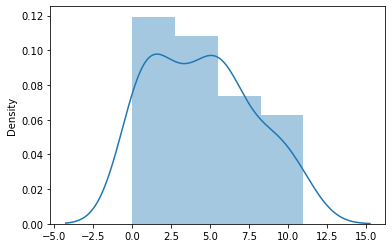

In [259]:
sns.distplot(np.argmax(classif_train, axis = 1))

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

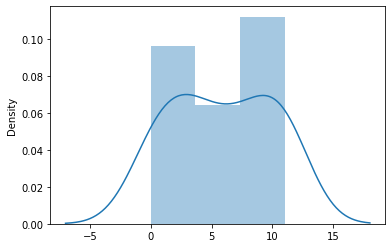

In [260]:
sns.distplot(np.argmax(classif_test, axis = 1))

In [170]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [183]:
IMG_SHAPE = X_train.shape[1:]
mobileNet = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    alpha=1.0,
    include_top=False,
    weights="imagenet"
)

In [184]:
mobileNet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [188]:
# model = models.Sequential()
# model.add(mobileNet)
# model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dense(4, 'sigmoid'))
# model.compile("adam", loss="MSE")

# model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dense(nb_classes, 'softmax'))
# model.compile("adam", loss="CategoricalCrossentropy")

In [203]:
input_ = Input(shape=IMG_SHAPE)
feature_extraction = mobileNet(input_)
pooling_layer = GlobalAveragePooling2D()(feature_extraction)
bounding_box_detection = Dense(4, 'sigmoid')(pooling_layer)
classification = Dense(len(classes), 'softmax')(pooling_layer)

model = Model(input_, [bounding_box_detection, classification])

In [206]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[1].layers[:fine_tune_at]:
    layer.trainable = False

In [226]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['input_8[0][0]']                
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_6 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[6][0]']   
 obalAveragePooling2D)                                                                      

In [234]:
model.compile(optimizer = "adam", loss = ["mse", "CategoricalCrossentropy"]) 

In [235]:
classif_train.shape

(64, 12)

In [236]:
model.fit(X_train, [bbs_train, classif_train], epochs = 50, verbose=1, shuffle=True)

Epoch 1/50
2/2 [==============================] - 3s 556ms/step - loss: 2.5320 - dense_7_loss: 0.0472 - dense_8_loss: 2.4848
Epoch 2/50
2/2 [==============================] - 1s 556ms/step - loss: 1.5510 - dense_7_loss: 0.0354 - dense_8_loss: 1.5156
Epoch 3/50
2/2 [==============================] - 1s 552ms/step - loss: 0.7980 - dense_7_loss: 0.0296 - dense_8_loss: 0.7685
Epoch 4/50
2/2 [==============================] - 1s 562ms/step - loss: 0.3162 - dense_7_loss: 0.0272 - dense_8_loss: 0.2890
Epoch 5/50
2/2 [==============================] - 1s 554ms/step - loss: 0.1065 - dense_7_loss: 0.0241 - dense_8_loss: 0.0824
Epoch 6/50
2/2 [==============================] - 1s 568ms/step - loss: 0.0385 - dense_7_loss: 0.0168 - dense_8_loss: 0.0217
Epoch 7/50
2/2 [==============================] - 1s 635ms/step - loss: 0.0208 - dense_7_loss: 0.0136 - dense_8_loss: 0.0072
Epoch 8/50
2/2 [==============================] - 1s 565ms/step - loss: 0.0111 - dense_7_loss: 0.0078 - dense_8_loss: 0.0033


In [238]:
model.history.history.keys()

dict_keys(['loss', 'dense_7_loss', 'dense_8_loss'])

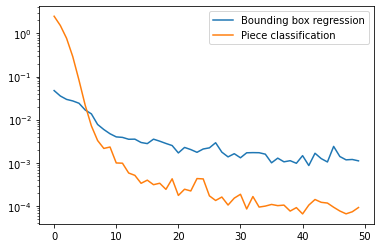

In [240]:
plt.plot(model.history.history['dense_7_loss'])
plt.plot(model.history.history['dense_8_loss'])
plt.yscale("log")

plt.legend(["Bounding box regression", "Piece classification"])

In [264]:
y_pred = model.predict(X_train)      

2/2 [==============================] - 1s 444ms/step


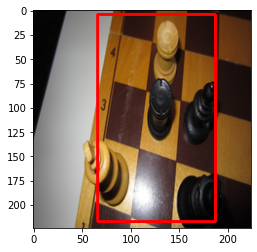

In [267]:
xmin,ymin,xmax,ymax = (y_pred[0][0] * 224).astype(int)
plt.imshow(cv2.rectangle(X_train[0], (xmin,ymin), (xmax,ymax), (255,0,0), 2))

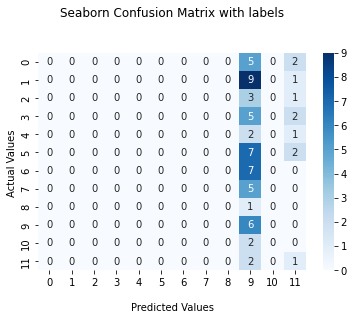

In [263]:
y_pred_classification = np.argmax(y_pred[1], axis = 1)

M = confusion_matrix(np.argmax(classif_train, axis = 1), y_pred_classification)
ax = sns.heatmap(M, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Display the visualization of the Confusion Matrix.
plt.show()

In [241]:
y_pred = model.predict(X_test)       

1/1 [==============================] - 1s 720ms/step


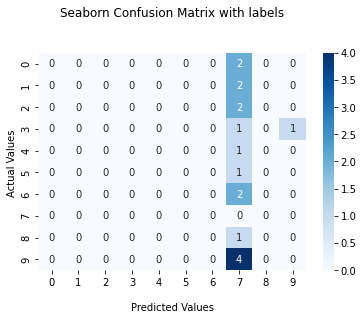

In [248]:
y_pred_classification = np.argmax(y_pred[1], axis = 1)

M = confusion_matrix(np.argmax(classif_test, axis = 1), y_pred_classification)
ax = sns.heatmap(M, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Display the visualization of the Confusion Matrix.
plt.show()

In [251]:
y_pred[1]

array([[7.69469377e-10, 2.93792481e-21, 4.27974213e-04, 2.84067534e-15,
        5.25137280e-13, 7.23506744e-16, 6.02772606e-13, 7.43573692e-05,
        1.57144037e-03, 8.81448209e-01, 6.03025455e-06, 1.16471946e-01],
       [1.71983469e-10, 9.70579622e-22, 4.77025838e-04, 1.68479417e-15,
        4.56194707e-13, 6.72025935e-16, 4.67490152e-12, 3.57601733e-04,
        3.28833470e-03, 8.30715477e-01, 1.08027471e-05, 1.65150702e-01],
       [5.04757347e-10, 3.47745074e-21, 1.40267645e-03, 6.75673989e-15,
        1.07045861e-12, 2.21557540e-15, 1.66070188e-13, 6.50586371e-05,
        5.96752099e-04, 8.36943626e-01, 5.53027394e-06, 1.60986289e-01],
       [2.58692379e-09, 7.08945225e-20, 2.69482704e-03, 2.02916636e-14,
        2.81037867e-12, 6.80160257e-15, 1.35240942e-11, 4.21986508e-04,
        3.05513619e-03, 4.58402038e-01, 5.22396113e-05, 5.35373807e-01],
       [1.93501215e-09, 3.82538964e-21, 4.66347160e-03, 2.14350056e-14,
        1.33557455e-12, 3.94999542e-15, 1.77076263e-13, 1.20

### Loading Yolo model

Loading weight

In [305]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))
 
    def reset(self):
        self.offset = 0

Define architecture

In [308]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                             {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

In [311]:
yolov3 = make_yolov3_model()

# load the weights
weight_reader = WeightReader('yolov3.weights')

# set the weights
weight_reader.load_weights(yolov3)

# save the model to file
yolov3.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

bounding box classes according to yolo model

In [321]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.get_score

def _sigmoid(x):
    return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

In [322]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [337]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    print(box1.xmin, box1.xmax, box2.xmin, box2.xmax)
    print(box1.ymin, box1.ymax, box2.ymin, box2.ymax)
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    print(union, intersect)
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
  
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red', linewidth = '2')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='red')
    # show the plot
    pyplot.show()

### Kmeans to determine anchors

In [382]:
length_bounding_box = np.vstack((bounding_box_scaled[:,2] - bounding_box_scaled[:,0], bounding_box_scaled[:,3] - bounding_box_scaled[:,1])).T

In [383]:
length_bounding_box.shape

(398, 2)

In [384]:
kmeans = []
for k in range(2,20):
    kmeans.append(KMeans(k, random_state=0).fit(length_bounding_box))

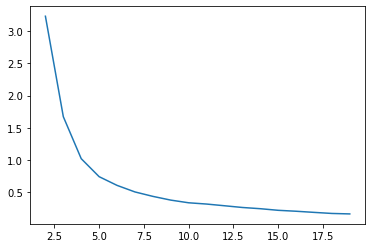

In [385]:
plt.plot(list(range(2,20)), [kmean.inertia_ for kmean in kmeans])

In [387]:
np.round(kmeans[5].cluster_centers_, 2)

array([[0.08, 0.15],
       [0.21, 0.7 ],
       [0.13, 0.3 ],
       [0.2 , 0.51],
       [0.05, 0.09],
       [0.11, 0.21],
       [0.15, 0.39]])

In [389]:
anchors = np.round(kmeans[5].cluster_centers_, 2)

# define the probability threshold for detected objects
class_threshold = 0.6

In [390]:
for image in img:
    yhat = yolov3.predict(np.expand_dims(image, axis = 0))
    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])

    boxes = list() 
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, height, width)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, height, width, height, width)

    # suppress non-maximal boxes
    do_nms(boxes, 0.5)

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, classes, class_threshold)

    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])

    # draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

1/1 [==============================] - 0s 192ms/step
[(1, 7, 7, 255), (1, 14, 14, 255), (1, 28, 28, 255)]


C:\Users\thoma\AppData\Local\Temp\ipykernel_2920\1574323152.py:24: RuntimeWarning: overflow encountered in exp
  return 1. /(1. + np.exp(-x))


IndexError: index 2 is out of bounds for axis 0 with size 2